### IMPORT

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for visualization

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [3]:

from sklearn.metrics import classification_report, confusion_matrix

### H2O AutoML Setup

In [4]:
# Install h2o if needed (uncomment if not installed)
# !pip install h2o

import h2o
from h2o.automl import H2OAutoML

# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 23+37-2369, mixed mode, sharing)
  Starting server from C:\Users\merve\AppData\Roaming\Python\Python312\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\merve\AppData\Local\Temp\tmpridjsggt
  JVM stdout: C:\Users\merve\AppData\Local\Temp\tmpridjsggt\h2o_merve_started_from_python.out
  JVM stderr: C:\Users\merve\AppData\Local\Temp\tmpridjsggt\h2o_merve_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Istanbul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,3 months
H2O_cluster_name:,H2O_from_python_merve_1f3yzz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.806 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


### Set up Data Frame

In [ ]:
df = pd.read_csv("C:\\Users\\merve\\Desktop\\01_classification_stellar\\data\\star_classification.csv")

In [7]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


### EDA

In [8]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    #print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [9]:
check_df(df)

##################### Shape #####################
(100000, 18)
##################### Types #####################
obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class              str
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object
##################### Head #####################
         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301      

In [10]:
def grab_col_names(dataframe, cat_th=15, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, cat_but_car, num_cols

In [11]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 100000
Variables: 18
cat_cols: 3
num_cols: 15
cat_but_car: 0
num_but_cat: 3


In [12]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

In [13]:
for col in cat_cols: 
        cat_summary(df, col)
   

          rerun_ID  Ratio
rerun_ID                 
301         100000  100.0
         cam_col   Ratio
cam_col                 
4          19573  19.573
3          18851  18.851
5          18537  18.537
2          17117  17.117
1          13227  13.227
6          12695  12.695
        class   Ratio
class                
GALAXY  59445  59.445
STAR    21594  21.594
QSO     18961  18.961


C:\Users\merve\AppData\Local\Temp\ipykernel_24216\3252793253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


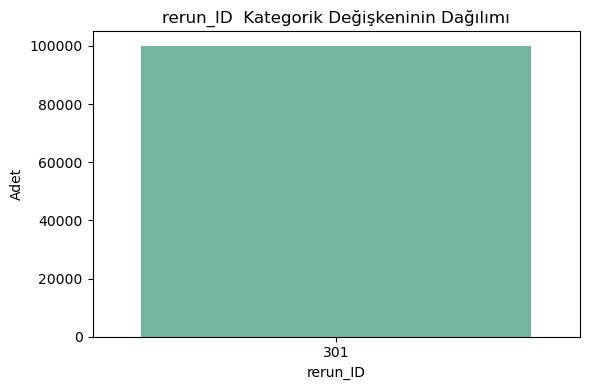

C:\Users\merve\AppData\Local\Temp\ipykernel_24216\3252793253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


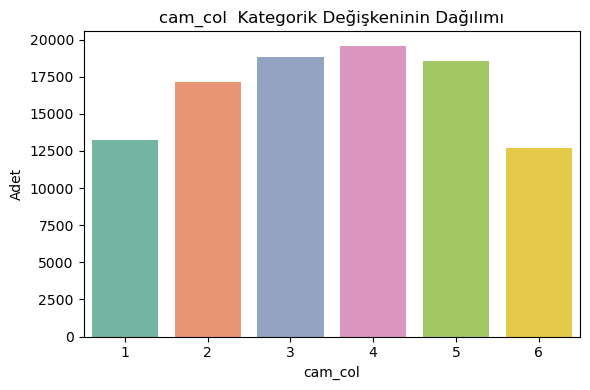

C:\Users\merve\AppData\Local\Temp\ipykernel_24216\3252793253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


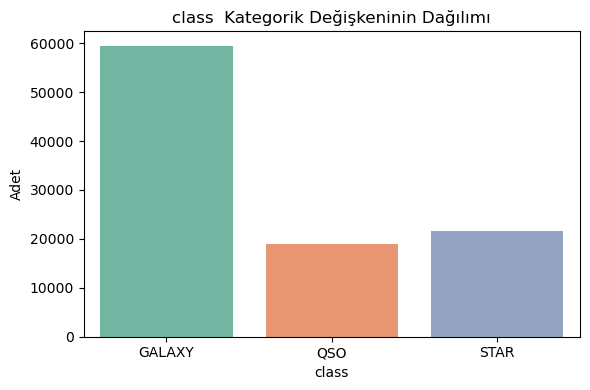

In [16]:
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, palette="Set2")
    plt.title(f"{col}  Kategorik Değişkeninin Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Adet")
    plt.tight_layout()
    plt.show()

count    1.000000e+05
mean     1.237665e+18
std      8.438560e+12
min      1.237646e+18
5%       1.237652e+18
10%      1.237654e+18
20%      1.237658e+18
30%      1.237661e+18
40%      1.237662e+18
50%      1.237663e+18
60%      1.237665e+18
70%      1.237668e+18
80%      1.237671e+18
90%      1.237679e+18
95%      1.237680e+18
99%      1.237680e+18
max      1.237681e+18
Name: obj_ID, dtype: float64


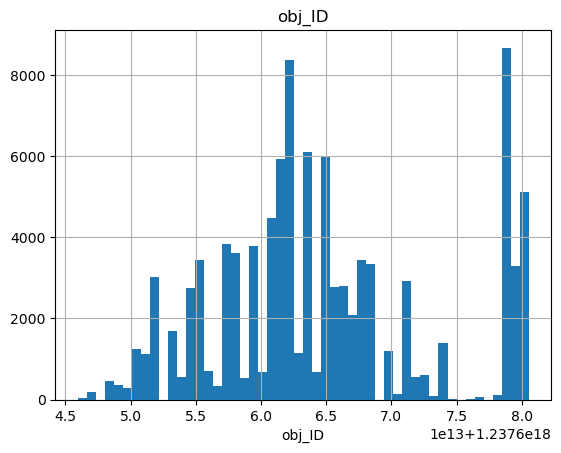

#####################################
count    100000.000000
mean        177.629117
std          96.502241
min           0.005528
5%           11.750808
10%          23.783165
20%         116.399219
30%         135.654002
40%         156.016785
50%         180.900700
60%         203.201928
70%         224.105956
80%         243.562323
90%         331.912643
95%         348.769819
99%         357.980799
max         359.999810
Name: alpha, dtype: float64


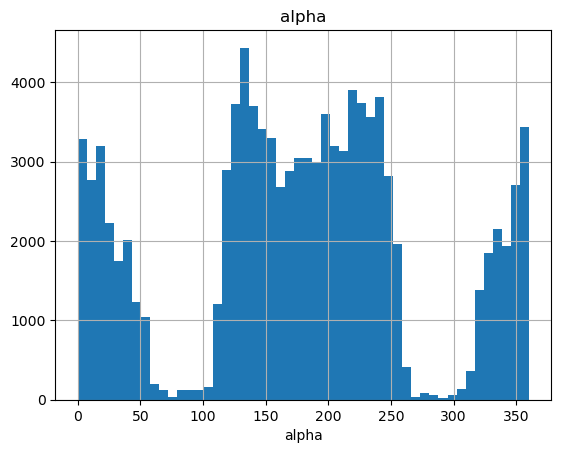

#####################################
count    100000.000000
mean         24.135305
std          19.644665
min         -18.785328
5%           -2.365670
10%          -0.659503
20%           2.279783
30%           9.515676
40%          17.374757
50%          23.645922
60%          30.345255
70%          36.504370
80%          43.167853
90%          51.013175
95%          56.701075
99%          65.142702
max          83.000519
Name: delta, dtype: float64


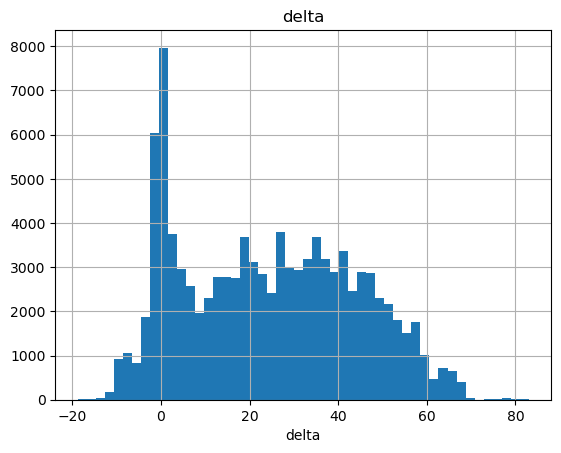

#####################################
count    100000.000000
mean         21.980468
std          31.769291
min       -9999.000000
5%           18.430930
10%          19.117051
20%          19.961014
30%          20.748600
40%          21.560668
50%          22.179135
60%          22.741812
70%          23.334252
80%          24.083744
90%          25.096416
95%          25.785050
99%          26.657341
max          32.781390
Name: u, dtype: float64


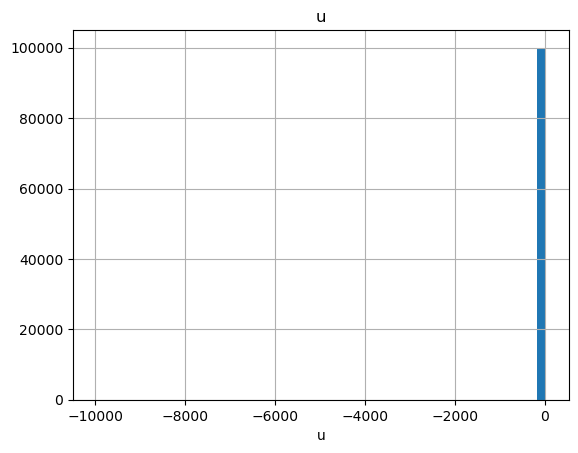

#####################################
count    100000.000000
mean         20.531387
std          31.750292
min       -9999.000000
5%           17.072820
10%          17.757718
20%          18.528204
30%          19.532486
40%          20.483238
50%          21.099835
60%          21.551900
70%          21.936786
80%          22.337636
90%          22.891737
95%          23.408262
99%          24.637623
max          31.602240
Name: g, dtype: float64


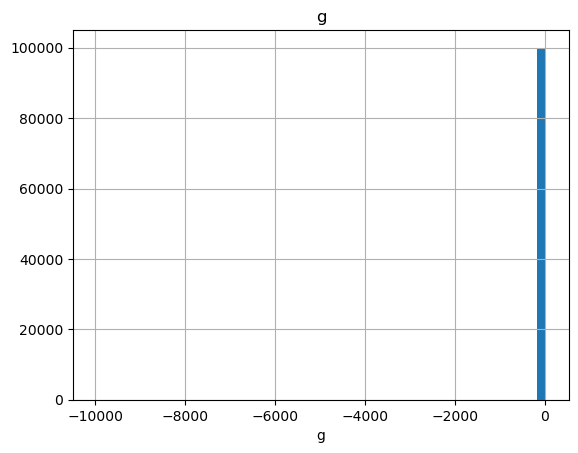

#####################################
count    100000.000000
mean         19.645762
std           1.854760
min           9.822070
5%           16.393046
10%          17.009738
20%          17.697234
30%          18.689505
40%          19.486618
50%          20.125290
60%          20.502848
70%          20.848339
80%          21.270734
90%          21.763206
95%          22.070249
99%          22.794967
max          29.571860
Name: r, dtype: float64


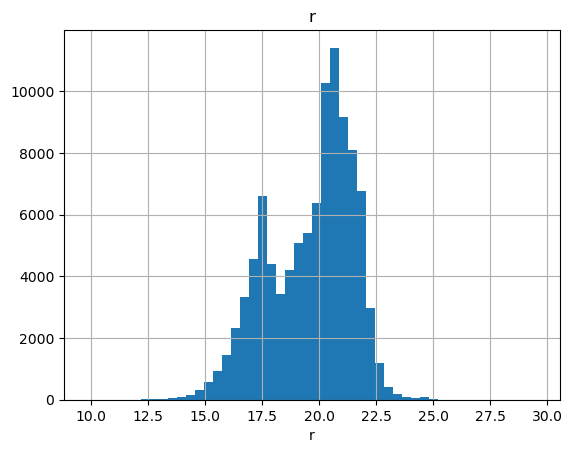

#####################################
count    100000.000000
mean         19.084854
std           1.757895
min           9.469903
5%           16.043819
10%          16.619008
20%          17.298682
30%          18.224892
40%          18.906586
50%          19.405145
60%          19.736628
70%          20.127593
80%          20.643606
90%          21.236341
95%          21.607623
99%          22.158517
max          32.141470
Name: i, dtype: float64


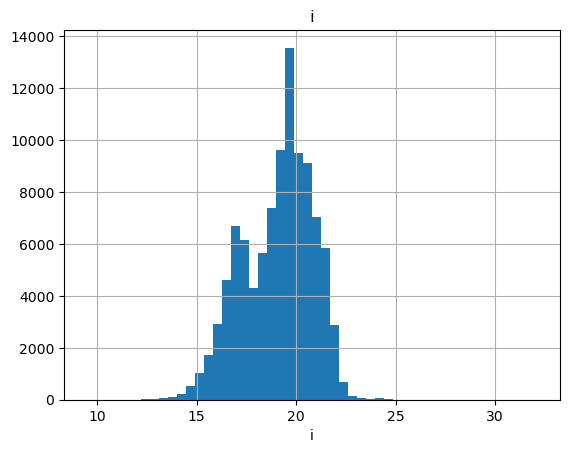

#####################################
count    100000.000000
mean         18.668810
std          31.728152
min       -9999.000000
5%           15.778155
10%          16.341922
20%          17.032588
30%          17.906282
40%          18.552554
50%          19.004595
60%          19.339320
70%          19.713277
80%          20.254234
90%          21.007802
95%          21.462771
99%          22.365484
max          29.383740
Name: z, dtype: float64


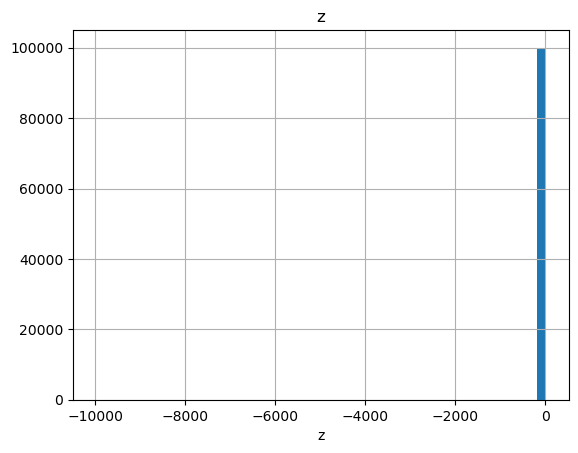

#####################################
count    100000.000000
mean       4481.366060
std        1964.764593
min         109.000000
5%         1412.000000
10%        2076.000000
20%        2831.000000
30%        3562.000000
40%        3840.000000
50%        4188.000000
60%        4576.000000
70%        5137.000000
80%        6004.000000
90%        7773.000000
95%        8038.000000
99%        8116.000000
max        8162.000000
Name: run_ID, dtype: float64


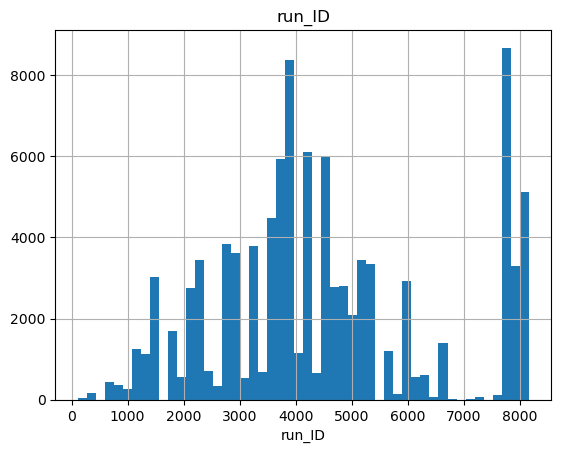

#####################################
count    100000.000000
mean        186.130520
std         149.011073
min          11.000000
5%           31.000000
10%          46.000000
20%          70.000000
30%          94.000000
40%         119.000000
50%         146.000000
60%         178.000000
70%         215.000000
80%         272.000000
90%         376.000000
95%         489.000000
99%         774.010000
max         989.000000
Name: field_ID, dtype: float64


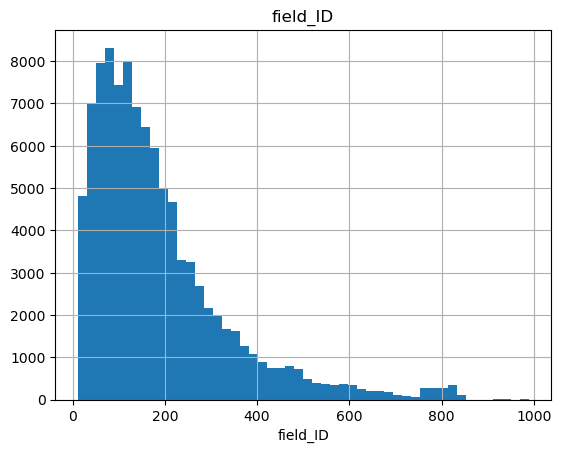

#####################################
count    1.000000e+05
mean     5.783882e+18
std      3.324016e+18
min      2.995191e+17
5%       8.186592e+17
10%      1.320828e+18
20%      2.336388e+18
30%      3.557915e+18
40%      4.739135e+18
50%      5.614883e+18
60%      6.799378e+18
70%      7.806119e+18
80%      8.824863e+18
90%      1.037534e+19
95%      1.174436e+19
99%      1.273962e+19
max      1.412694e+19
Name: spec_obj_ID, dtype: float64


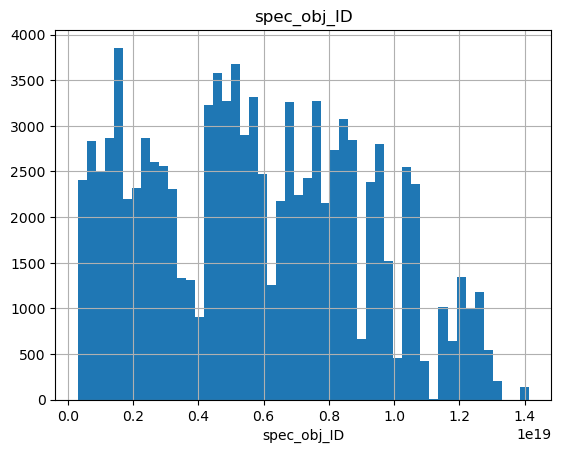

#####################################
count    100000.000000
mean          0.576661
std           0.730707
min          -0.009971
5%           -0.000326
10%          -0.000101
20%           0.000273
30%           0.097152
40%           0.228664
50%           0.424173
60%           0.526129
70%           0.621392
80%           0.823949
90%           1.563901
95%           2.187728
99%           3.127080
max           7.011245
Name: redshift, dtype: float64


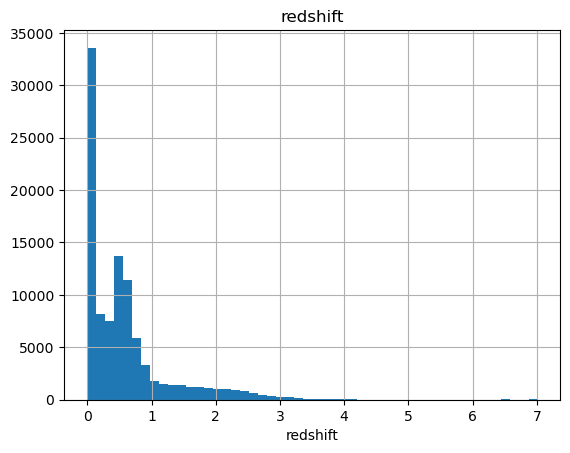

#####################################
count    100000.000000
mean       5137.009660
std        2952.303351
min         266.000000
5%          727.000000
10%        1173.000000
20%        2075.000000
30%        3160.000000
40%        4209.000000
50%        4987.000000
60%        6039.000000
70%        6933.000000
80%        7838.000000
90%        9215.000000
95%       10431.000000
99%       11315.000000
max       12547.000000
Name: plate, dtype: float64


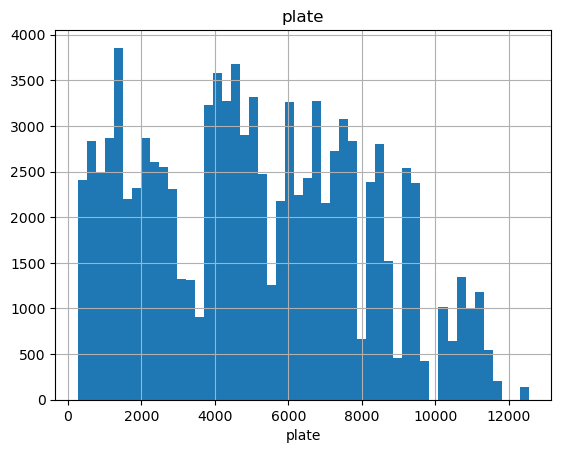

#####################################
count    100000.000000
mean      55588.647500
std        1808.484233
min       51608.000000
5%        52337.450000
10%       52751.000000
20%       53739.000000
30%       54825.000000
40%       55539.000000
50%       55868.500000
60%       56214.000000
70%       56570.000000
80%       57312.000000
90%       58043.000000
95%       58200.000000
99%       58485.000000
max       58932.000000
Name: MJD, dtype: float64


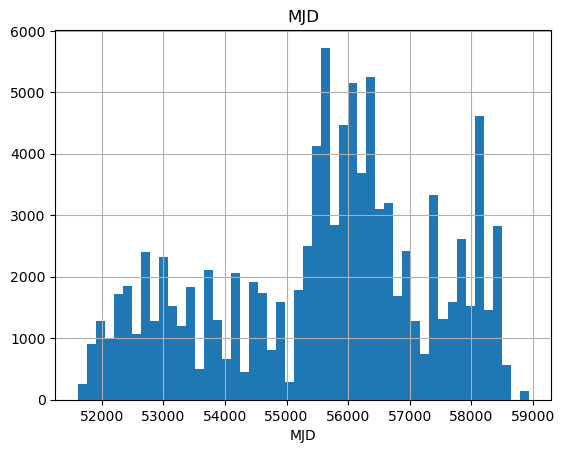

#####################################
count    100000.000000
mean        449.312740
std         272.498404
min           1.000000
5%           46.000000
10%          90.000000
20%         177.000000
30%         264.000000
40%         348.000000
50%         433.000000
60%         519.000000
70%         602.000000
80%         715.000000
90%         854.000000
95%         926.000000
99%         986.000000
max        1000.000000
Name: fiber_ID, dtype: float64


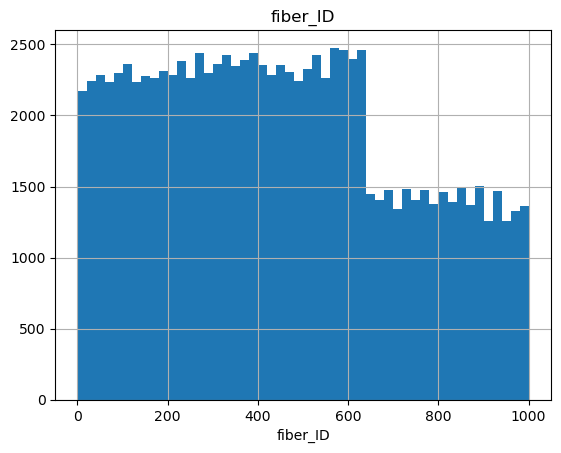

#####################################


In [17]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df, col, True)

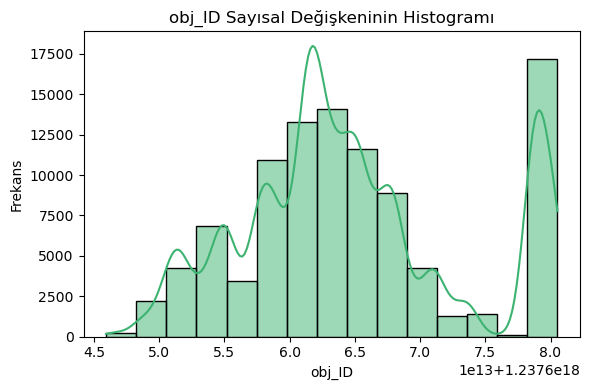

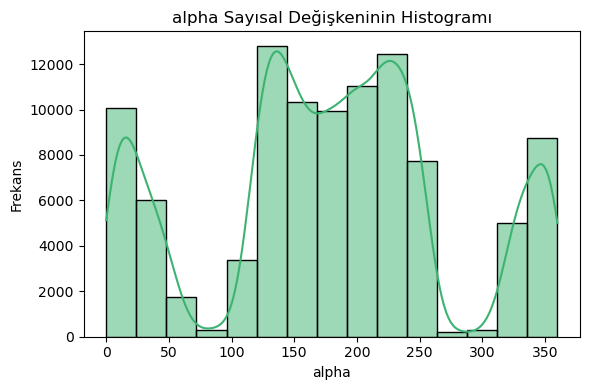

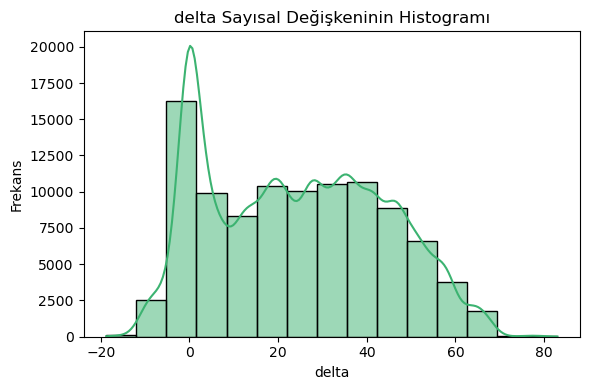

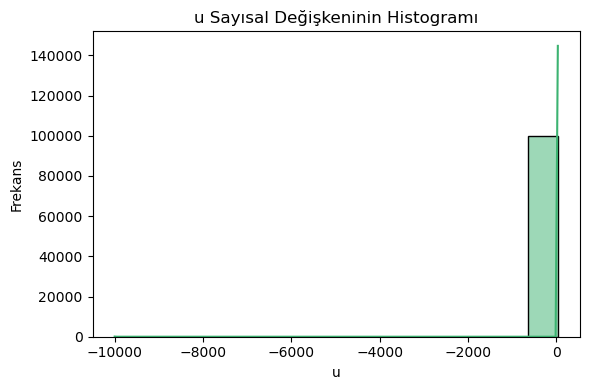

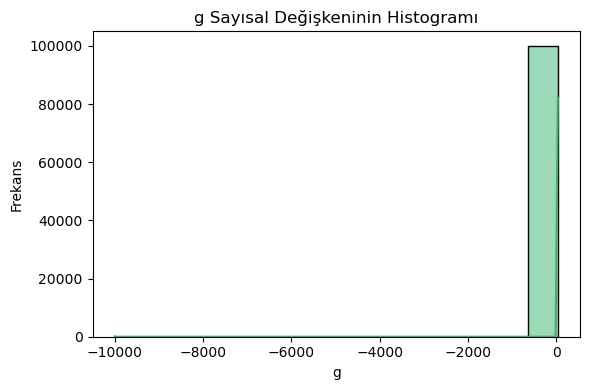

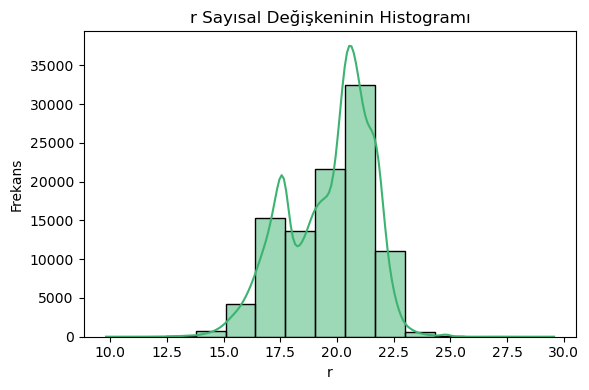

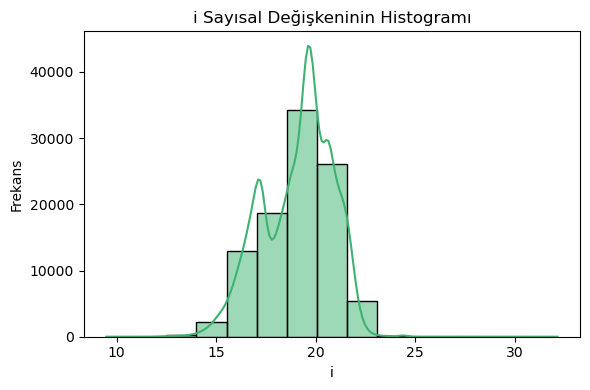

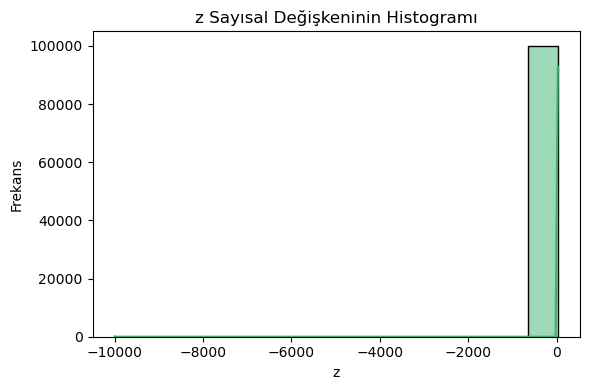

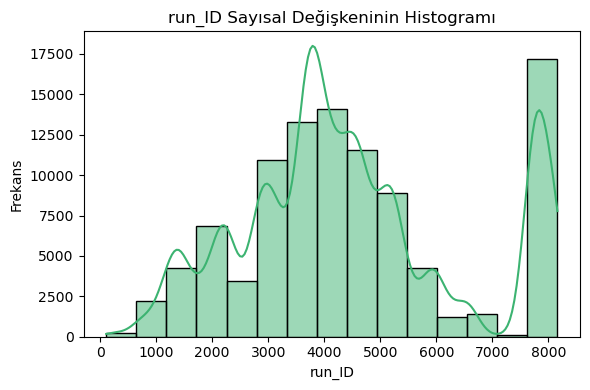

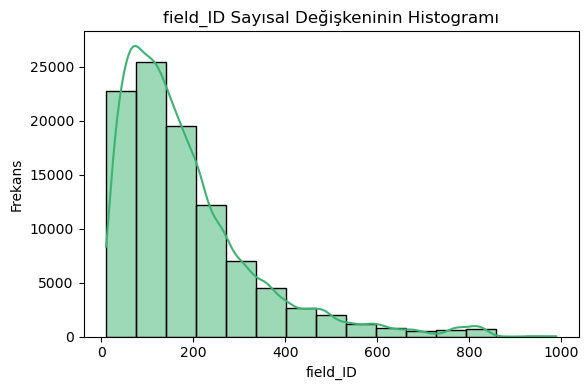

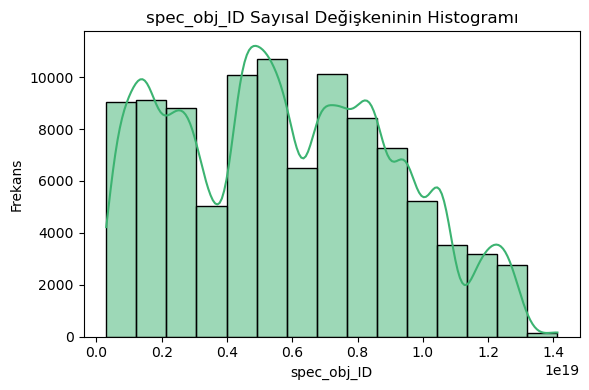

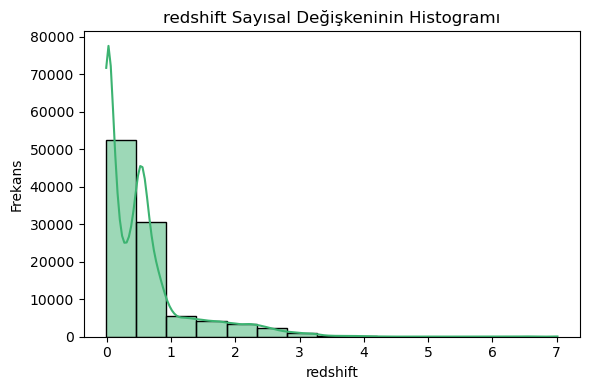

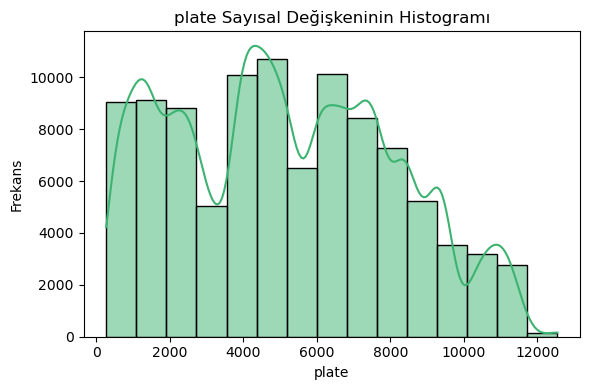

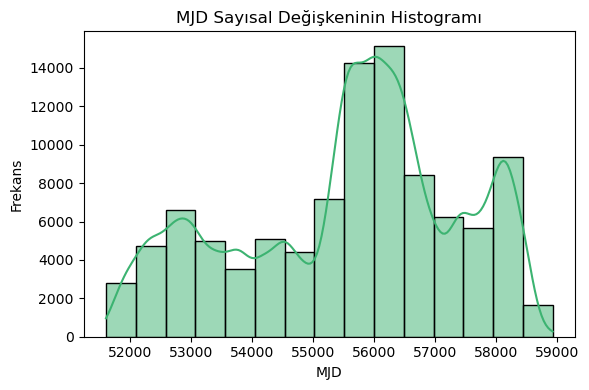

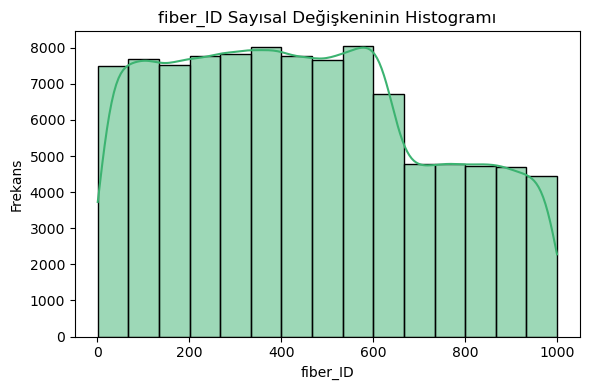

In [18]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=15, kde=True, color="mediumseagreen")
    plt.title(f"{col} Sayısal Değişkeninin Histogramı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.tight_layout()
    plt.show()

In [20]:
corr = df[num_cols].corr()
corr

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
obj_ID,1.000000,-0.013735,-0.301237,0.015310,0.015710,0.153891,0.147670,0.013811,1.000000,0.031498,0.239461,0.065400,0.239460,0.262687,0.067178
alpha,-0.013735,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,-0.013737,-0.165577,-0.002553,0.001667,-0.002554,0.019943,0.030464
delta,-0.301237,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,-0.301238,-0.173416,0.112329,0.031638,0.112329,0.107333,0.028250
u,0.015310,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.015309,-0.008374,0.029997,0.014309,0.029997,0.031997,0.016305
g,0.015710,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.015710,-0.008852,0.039443,0.022954,0.039443,0.040274,0.017470
r,0.153891,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.153889,-0.026423,0.655245,0.433241,0.655243,0.671180,0.223106
i,0.147670,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.147668,-0.026679,0.661641,0.492383,0.661640,0.672523,0.214787
z,0.013811,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.013811,-0.008903,0.037813,0.030380,0.037813,0.037469,0.014668
run_ID,1.000000,-0.013737,-0.301238,0.015309,0.015710,0.153889,0.147668,0.013811,1.000000,0.031498,0.239460,0.065400,0.239459,0.262687,0.067165
field_ID,0.031498,-0.165577,-0.173416,-0.008374,-0.008852,-0.026423,-0.026679,-0.008903,0.031498,1.000000,-0.083471,-0.021331,-0.083471,-0.095064,-0.012337


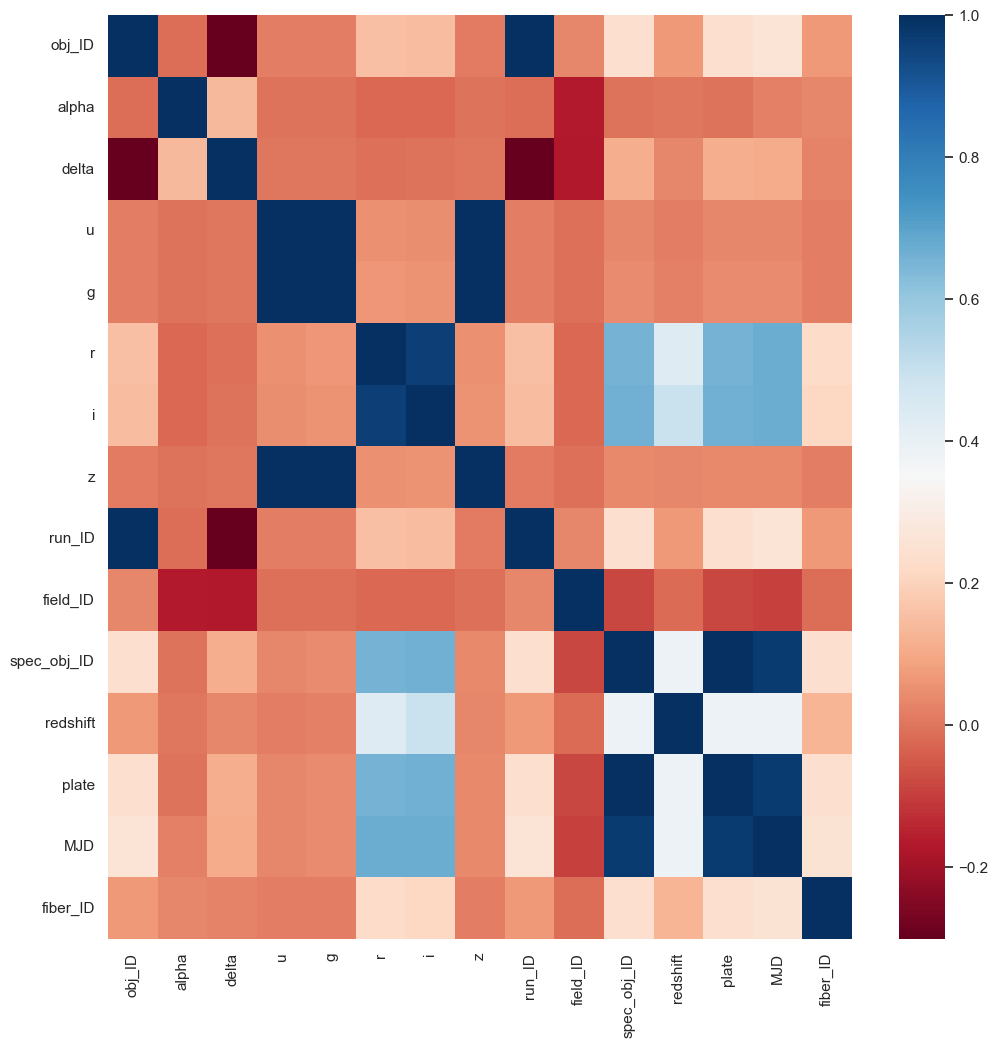

In [22]:
# Korelasyonların gösterilmesi
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu")
plt.show()


###  Data Preprocessing & Feature Engineering

In [23]:
def apply_feature_engineering(df):

    # Filtre değerleri genellikle 0-30 arasındadır, hatalı -9999 değerlerini eliyoruz
    filtreler = ['u', 'g', 'r', 'i', 'z']
    for f in filtreler:
        df = df[(df[f] > 0) & (df[f] < 40)]
    
    # Redshift için makul bir sınır (Yıldızlar için hafif negatif olabilir)
    df = df[df['redshift'] > -0.1].copy()

    # 2. Renk İndeksleri Oluşturma (Fiziksel Çıkarım: Renk = Fark)
    # Bu işlem, spektrumun eğimini modele öğretir
    df['u-g'] = df['u'] - df['g']
    df['g-r'] = df['g'] - df['r']
    df['r-i'] = df['r'] - df['i']
    df['i-z'] = df['i'] - df['z']

    # 3. Gereksiz ve Teknik Sütunları Silme
    # MJD, plate ve spec_obj_ID arasındaki %97+ korelasyon nedeniyle bilgi tekrarını önlüyoruz
    # Ayrıca obj_ID gibi teknik kimlikleri çıkarıyoruz
    silinecek_sutunlar = [
        'obj_ID', 'run_ID', 'rerun_ID', 'field_ID', 
        'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'
    ]
    df = df.drop(columns=silinecek_sutunlar)

    return df

# Uygulama:
df_final = apply_feature_engineering(df)

# Yeni korelasyonu kontrol et
print(df_final[['u-g', 'g-r', 'r-i', 'redshift']].corr())

               u-g       g-r       r-i  redshift
u-g       1.000000  0.283985  0.175064 -0.232527
g-r       0.283985  1.000000  0.519007 -0.209359
r-i       0.175064  0.519007  1.000000 -0.123634
redshift -0.232527 -0.209359 -0.123634  1.000000


In [24]:
new_cat_cols, new_cat_but_car, new_num_cols = grab_col_names(df_final)

Observations: 99999
Variables: 14
cat_cols: 2
num_cols: 12
cat_but_car: 0
num_but_cat: 2


In [25]:
df_final.head()

,alpha,delta,u,g,r,i,z,cam_col,class,redshift,u-g,g-r,r-i,i-z
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,GALAXY,0.634794,1.60352,1.88029,1.22928,0.37202
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,GALAXY,0.779136,1.94571,0.24744,1.41632,-0.44615
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,GALAXY,0.644195,2.59918,2.05413,1.26119,0.40030
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,GALAXY,0.932346,-1.63974,2.16494,1.10708,1.25444
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,GALAXY,0.116123,1.85690,1.08281,0.52036,0.43250


In [26]:
##3.AYKIRI DEĞER ANALİZİ
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [27]:
for col in new_num_cols:
    if col != "class":
      print(col, check_outlier(df_final, col))

alpha False
delta False
u False
g True
r True
i True
z True
redshift True
u-g True
g-r True
r-i True
i-z True


In [28]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in new_num_cols:
    if col != "class":
        replace_with_thresholds(df_final,col)

In [29]:
for col in new_num_cols:
    if col != "class":
      print(col, check_outlier(df_final, col))

alpha False
delta False
u False
g False
r False
i False
z False
redshift False
u-g False
g-r False
r-i False
i-z False


### Modelling - H2O AutoML

In [30]:
# 1. Pandas DataFrame'i H2O Frame'e çevirme
hf = h2o.H2OFrame(df_final)

# Hedef değişkeni faktör (kategorik) olarak ayarlama
hf['class'] = hf['class'].asfactor()

print("H2O Frame oluşturuldu!")
print(hf.types)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
H2O Frame oluşturuldu!
{'alpha': 'real', 'delta': 'real', 'u': 'real', 'g': 'real', 'r': 'real', 'i': 'real', 'z': 'real', 'cam_col': 'int', 'class': 'enum', 'redshift': 'real', 'u-g': 'real', 'g-r': 'real', 'r-i': 'real', 'i-z': 'real'}


In [31]:
# 2. Train-Test split yapma
train, test = hf.split_frame(ratios=[0.75], seed=42)

print(f"Train set boyutu: {train.nrow} satır")
print(f"Test set boyutu: {test.nrow} satır")

Train set boyutu: 74983 satır
Test set boyutu: 25016 satır


In [32]:
# 3. Hedef ve feature değişkenlerini tanımlama
y = 'class'  # Hedef değişken
x = hf.columns  # Tüm sütunlar
x.remove(y)  # Hedef değişkeni feature'lardan çıkar

print(f"Hedef değişken: {y}")
print(f"Feature sayısı: {len(x)}")
print(f"Feature'lar: {x}")

Hedef değişken: class
Feature sayısı: 13
Feature'lar: ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'redshift', 'u-g', 'g-r', 'r-i', 'i-z']


In [33]:
# 4. H2O AutoML ile model eğitimi
# max_runtime_secs: AutoML'in kaç saniye çalışacağı (istediğiniz süreyi ayarlayabilirsiniz)
# max_models: Maksimum kaç model deneneceği
# seed: Tekrarlanabilirlik için

aml = H2OAutoML(max_runtime_secs=300,  # 5 dakika (isteğe göre artırabilirsiniz)
                max_models=20,          # Maksimum 20 model denenecek
                seed=42,
                balance_classes=True,   # Sınıflar dengesiz ise True yapın
                verbosity="info")       # Detaylı çıktı için

# Model eğitimi başlat
print("H2O AutoML eğitimi başlıyor...")
aml.train(x=x, y=y, training_frame=train)
print("Eğitim tamamlandı!")

H2O AutoML eğitimi başlıyor...
AutoML progress: |Failed polling AutoML progress log: Server error java.lang.IllegalArgumentException:
  Error: No enum constant water.logging.LoggingLevel.info
  Request: GET /99/AutoML/AutoML_1_20260225_142732@@class
    params: {'verbosity': 'info'}

Failed polling AutoML progress log: Server error java.lang.IllegalArgumentException:
  Error: No enum constant water.logging.LoggingLevel.info
  Request: GET /99/AutoML/AutoML_1_20260225_142732@@class
    params: {'verbosity': 'info'}

Failed polling AutoML progress log: Server error java.lang.IllegalArgumentException:
  Error: No enum constant water.logging.LoggingLevel.info
  Request: GET /99/AutoML/AutoML_1_20260225_142732@@class
    params: {'verbosity': 'info'}

Failed polling AutoML progress log: Server error java.lang.IllegalArgumentException:
  Error: No enum constant water.logging.LoggingLevel.info
  Request: GET /99/AutoML/AutoML_1_20260225_142732@@class
    params: {'verbosity': 'info'}

Failed 

### Leadboard & Evaluation

In [34]:
# 5. Leaderboard'u görüntüleme (En iyi modeller)
lb = aml.leaderboard
print("En İyi 10 Model:")
lb.head(rows=10)

En İyi 10 Model:


model_id,mean_per_class_error,logloss,rmse,mse
GBM_3_AutoML_1_20260225_142732,0.027638,0.0672105,0.128843,0.0166006
GBM_2_AutoML_1_20260225_142732,0.0277605,0.0671521,0.12924,0.0167031
GBM_4_AutoML_1_20260225_142732,0.028046,0.0696495,0.129527,0.0167771
GBM_1_AutoML_1_20260225_142732,0.0280843,0.0671956,0.129186,0.0166891
DRF_1_AutoML_1_20260225_142732,0.0394495,0.107149,0.153571,0.0235842
XRT_1_AutoML_1_20260225_142732,0.0400511,0.105984,0.153885,0.0236806
GLM_1_AutoML_1_20260225_142732,0.0528743,0.161069,0.202065,0.0408302


In [35]:
# 6. En iyi modeli al
best_model = aml.leader
print(f"En iyi model: {best_model.model_id}")
print(f"\nModel tipi: {best_model.algo}")

En iyi model: GBM_3_AutoML_1_20260225_142732

Model tipi: gbm


In [36]:
# 7. Test seti üzerinde tahmin yapma
predictions = best_model.predict(test)
predictions.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,GALAXY,QSO,STAR
GALAXY,0.998686,0.0012033,0.000110897
STAR,0.00258163,0.000236338,0.997182
GALAXY,0.939648,0.059748,0.000603662
GALAXY,0.997717,0.00214855,0.000134761
GALAXY,0.980841,0.0183692,0.000789667
QSO,0.00271812,0.997059,0.000222565
GALAXY,0.979346,0.020227,0.00042686
GALAXY,0.979689,0.0199999,0.000310754
GALAXY,0.997401,0.00230914,0.000289489
STAR,0.00321299,0.00040736,0.99638


In [37]:
# 8. Model performansını değerlendirme
perf = best_model.model_performance(test)
print(perf)

ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.016617781385213318
RMSE: 0.12890997395552184
LogLoss: 0.06716382898177556
Mean Per-Class Error: 0.027205077934639162
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
GALAXY    QSO    STAR    Error        Rate
--------  -----  ------  -----------  ------------
14729     153    24      0.0118744    177 / 14.906
325       4386   1       0.0691851    326 / 4.712
3         0      5395    0.000555761  3 / 5.398
15057     4539   5420    0.0202271    506 / 25.016

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.979773
2    0.99996
3    1


C:\Users\merve\AppData\Roaming\Python\Python312\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\merve\AppData\Roaming\Python\Python312\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


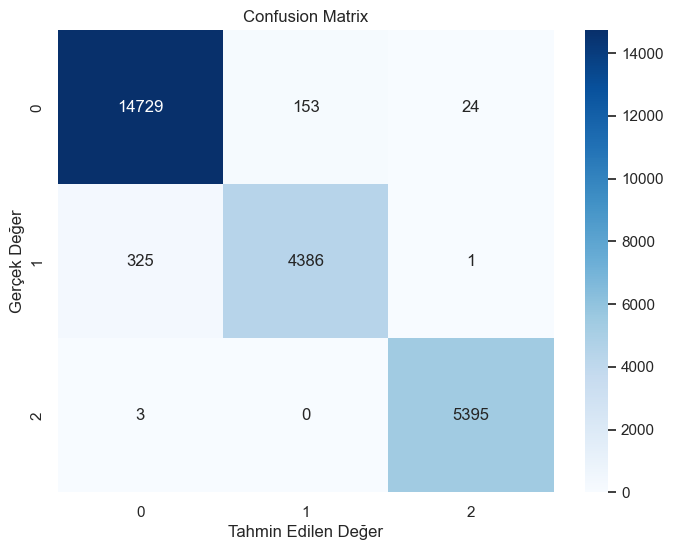

In [38]:
# 9. Confusion Matrix görselleştirme
# Tahminleri ve gerçek değerleri pandas'a çevirme
y_pred = predictions['predict'].as_data_frame()['predict']
y_true = test['class'].as_data_frame()['class']

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.show()

In [39]:
# 10. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     14906
         QSO       0.97      0.93      0.95      4712
        STAR       1.00      1.00      1.00      5398

    accuracy                           0.98     25016
   macro avg       0.98      0.97      0.98     25016
weighted avg       0.98      0.98      0.98     25016



In [40]:
# 11. Feature Importance (Değişken Önem Dereceleri)
# Bazı modeller için çalışır (StackedEnsemble için çalışmayabilir)
try:
    var_imp = best_model.varimp(use_pandas=True)
    if var_imp is not None:
        plt.figure(figsize=(10, 6))
        top_n = min(15, len(var_imp))
        var_imp_top = var_imp.head(top_n)
        plt.barh(var_imp_top['variable'], var_imp_top['relative_importance'])
        plt.xlabel('Önem Derecesi')
        plt.title(f'Top {top_n} Önemli Değişkenler')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
except:
    print("Bu model için feature importance mevcut değil.")

Bu model için feature importance mevcut değil.


<Figure size 1000x600 with 0 Axes>